In [1]:
import torch
from torch import nn
from d2l import torch as d2l
%matplotlib inline

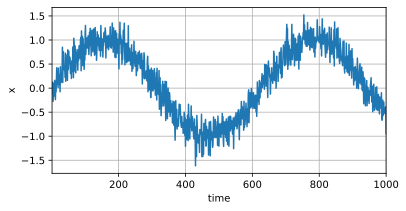

In [3]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们将这个序列转换为模型的特征－标签（feature-label）对。基于嵌⼊维度τ，我们将数据映射为数据对yt = xt 和xt = [xt−τ , . . . , xt−1]。这⽐我们提供的数据样本少了τ个，因为我们没有⾜够的历史记录来描述前τ个数据样本。⼀个简单的解决办法是：如果拥有⾜够⻓的序列就丢弃这⼏项；另⼀个⽅法是⽤零填充序列。在这⾥，我们仅使⽤前600个“特征－标签”对进⾏训练。

In [5]:
tau = 4
features = torch.zeros((T - tau, tau))

In [6]:
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [10]:
labels.shape

torch.Size([996, 1])

In [11]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [12]:
# 初始化⽹络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal(m.weight)


# ⼀个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net


# 平⽅损失。注意：MSELoss计算平⽅误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [13]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.066312
epoch 2, loss: 0.059041
epoch 3, loss: 0.056053
epoch 4, loss: 0.055428
epoch 5, loss: 0.053466


C:\Users\boss\AppData\Local\Temp\ipykernel_15712\2449584725.py:4: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)


由于训练损失很小，因此我们期望模型能有很好的工作效果。让我们看看这在实践中意味着什么。首先是检查模型预测下一个时间步的能力，也就是单步预测（one-step-ahead prediction）。

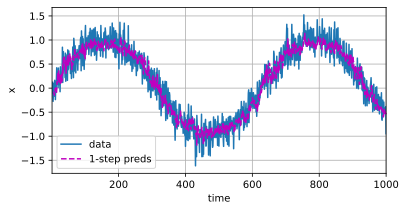

In [16]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

通常，对于直到xt的观测序列，其在时间步t + k处的预测输出xˆt+k 称为k步预测（k-step-ahead-prediction）。由于我们的观察已经到了x604，它的k步预测是xˆ604+k。换句话说，我们必须使用我们自己的预测（而不是原始数据）来进行多步预测。让我们看看效果如何。

In [19]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1))
    )

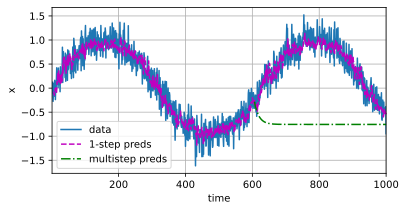

In [20]:
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

In [ ]:
"""
如上⾯的例⼦所⽰，绿线的预测显然并不理想。经过⼏个预测步骤之后，预测的结果很快就会衰减到⼀个常数。为什么这个算法效果这么差呢？事实是由于错误的累积：假设在步骤1之后，我们积累了⼀些错误ϵ1 = ¯ϵ。
于是，步骤2的输⼊被扰动了ϵ1，结果积累的误差是依照次序的ϵ2 = ¯ϵ + cϵ1，其中c为某个常数，后⾯的预测误差依此类推。因此误差可能会相当快地偏离真实的观测结果。例如，未来24⼩时的天⽓预报往往相当准确，但超过这⼀点，精度就会迅速下降。
"""

In [21]:
max_steps = 64

In [22]:
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来⾃x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来⾃（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

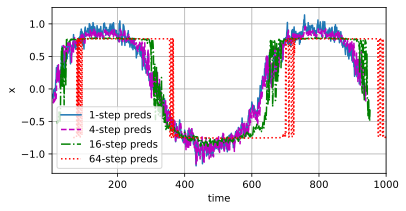

In [23]:
steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))